## Github Repo Metrics Using GraphQL API ##

In [70]:
%matplotlib inline

import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import datetime as dt
from IPython.display import display
import numpy as np
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from string import Template
from matplotlib.ticker import MaxNLocator

In [71]:
analyzer = SentimentIntensityAnalyzer()

ownerQuery = Template(''' 
{ 
    repositoryOwner(login : \"$owner\") {
        login repositories (first : 100) {
            edges {
                node {
                    name
                    diskUsage
                    forkCount 
                }
            }
            totalCount
        } 
    } 
} 
''')

repoQuery = Template(''' 
{ 
    repository(owner: \"$owner\", name: \"$repo\") { 
        forkCount
        watchers(first: 10) {
            totalCount
        }
        stargazers(first: 10) {
            totalCount
        }
        
        commitComments(first: 10) {
            edges {
                node {
                    bodyText
                    reactions(first: 10) {
                        edges {
                            node {
                                content
                            }
                        }
                    }
                }
            }
        }
        pullRequests(first: 10) { 
            totalCount
            edges { 
                node { 
                    createdAt
                    closedAt
                    closed
                    merged
                    mergedAt
                    comments(first: 10) {
                        edges {
                            node {
                                bodyText
                            }
                        }
                    } 
                } 
            } 
        } 
        issues(first: 10) {
            totalCount
            edges {
                node {
                    createdAt
                    closedAt
                    closed
                }
            }
        }
    }
}
''')


In [72]:
def getSentimentAPI(phrase):
    endpointSentAPI = 'http://text-processing.com/api/sentiment/'    
    r = requests.post(endpointSentAPI, {"text": phrase})
    return r.json()

def acquireOwnerRepos(ownerName, token):
    endpointGitHub = 'https://api.github.com/graphql'
    headersGitHub = {'Authorization': 'bearer ' + token}
    query = ownerQuery.substitute(owner=ownerName)
    r = requests.post(endpointGitHub, json.dumps({"query": query}), headers=headersGitHub)
    data = r.json()['data']['repositoryOwner']['repositories']['edges']
    repos = []
    for repo in data:
        repos.append(repo['node']['name'])
    return repos

def computeVaderSentiment(data):
    prData = data['pullRequests']['edges']

    neg = 0
    pos = 0
    neu = 0
    numMessages = 0
    
    for node in prData:
        edges = node['node']['comments']['edges']
        for cnode in edges:
            phrase = cnode['node']['bodyText']
            numMessages+=1
            vaderScores = analyzer.polarity_scores(phrase)
            neg += vaderScores['neg']
            pos += vaderScores['pos']
            neu += vaderScores['neu']
            
    if(numMessages > 0):
        neg = neg/numMessages
        pos = pos/numMessages
        neu = neu/numMessages
        total = neg + pos + neu
        neg = neg*100.0/total
        neu = neu*100.0/total
        pos = pos*100.0/total          
    return neg, neu, pos

def parseGitHubUTCTimeStamp(ts):
    return dt.datetime.strptime(ts, '%Y-%m-%dT%H:%M:%SZ')

def determineResolutionTime(opened, closed):
    td = closed - opened
    return abs(td.days)

def computePRResponseTimes(repoData):
    prData = repoData['pullRequests']['edges']
    prTimes = []
    for node in prData:
        if node['node']['closed'] == True:
            turnaround = determineResolutionTime(parseGitHubUTCTimeStamp(node['node']['closedAt']),parseGitHubUTCTimeStamp(node['node']['createdAt']))
            prTimes.append(turnaround)
    return prTimes
    
def acquireRepoData(ownerName, repoName, token):
    endpointGitHub = 'https://api.github.com/graphql'
    headersGitHub = {'Authorization': 'bearer ' + token}
    
    query = repoQuery.substitute(owner=ownerName,repo=repoName)
    r = requests.post(endpointGitHub, json.dumps({"query": query}), headers=headersGitHub)
    return r.json()['data']['repository']


In [73]:
repo_data = acquireRepoData('eldritchjs', 'equoid-data-handler', '5b151dd275afed8d9e51f4fb063b4aa36305c346')
sentiments = computeVaderSentiment(repo_data)

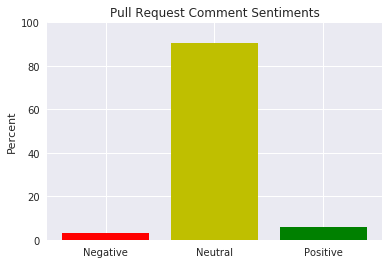

In [74]:
ind = np.arange(1, 4)

pneg, pneu, ppos = plt.bar(ind, sentiments)
pneg.set_facecolor('r')
pneu.set_facecolor('y')
ppos.set_facecolor('g')
plt.xticks(ind,['Negative', 'Neutral', 'Positive'])
plt.ylim([0, 100])
plt.ylabel('Percent')
plt.title('Pull Request Comment Sentiments')
plt.show()

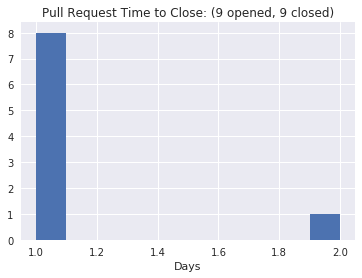

In [104]:
prTimes = computePRResponseTimes(repo_data)
openedPRs = repo_data['pullRequests']['totalCount']

plt.hist(prTimes, color = 'red')

titleStr=('Pull Request Time to Close: (' + str(openedPRs) + ' opened, ' + str(len(foo)) + ' closed)')
axes = plt.gca()
axes.set(ylabel="",xlabel="Days")
plt.title(titleStr)
axes.yaxis.set_major_locator(MaxNLocator(integer=True))
#axes.set_xlim([0,max(prTimes)+2])


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
import pandas as pd
from dash.dependencies import Input, Output

In [ ]:
app = dash.Dash()

#app.layout = html.Div([
#    html.Div()
#    dcc.Input(id='owner-id', value='Enter owner name', type='text'),
#    dcc.Input(id='repo-id', value='Enter repo name', type='text'),
#    dcc.Input(id='token-id', value='Enter Github API token', type='text'),
#    html.Div(id='input-div')
#])
repo_name = ''
user_name = ''

app.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Input(id='owner-id', value='Enter Github user name', type='text'),
            dcc.Dropdown(
                id='repolist-dropdown'
            )
        ],
        style={'width': '48%', 'display': 'inline-block'}),
    ]),

    dcc.Graph(id='sentiment-graphic')
])

@app.callback(
    dash.dependencies.Output('repolist-dropdown', 'options'),
    [dash.dependencies.Input('owner-id', 'value')])
def update_repo_dropdown(owner_name):
    user_name = owner_name
    repos = acquireOwnerRepos(owner_name, '5b151dd275afed8d9e51f4fb063b4aa36305c346')
    return[{'label': i, 'value': i} for i in repos]

@app.callback(
    dash.dependencies.Output('sentiment-graphic', 'figure'),
    [dash.dependencies.Input('repolist-dropdown', 'value')])
def update_sentiment_graph(repo_selected):
    repo_name = repo_selected
    print('username: ' + user_name)
    print(' reponame: ' + repo_name)
    repo_data = acquireRepoData('eldritchjs', 'equoid-data-handler', '5b151dd275afed8d9e51f4fb063b4aa36305c346')
    sentiments = computeVaderSentiment(repo_data)
    indices = ('Neg', 'Neu', 'Pos')
    return {
        'data': [go.Bar(
            x=indices,
            y=sentiments
        )],
        'layout': go.Layout(
            xaxis={
                'title': 'PR Comment Sentiment for ',
                'type': 'linear'
            },
            yaxis={
                'title': 'Percentage',
                'type': 'linear'
            }
        )
    }

app.run_server(debug=False)


In [ ]:
from IPython import display
def show_app(app,  # type: dash.Dash
             port=8051,
             width=960,
             height=720,
             offline=True,
             style=True,
             **dash_flask_kwargs):
    """
    Run the application inside a Jupyter notebook and show an iframe with it
    :param app:
    :param port:
    :param width:
    :param height:
    :param offline:
    :return:
    """
    url = 'http://localhost:%d' % port
    iframe = '<iframe src="{url}" width={width} height={height}></iframe>'.format(url=url,
                                                                                  width=width,
                                                                                  height=height)
    display.display_html(iframe, raw=True)
    if offline:
        app.css.config.serve_locally = True
        app.scripts.config.serve_locally = True
    if style:
        external_css = ["https://fonts.googleapis.com/css?family=Raleway:400,300,600",
                        "https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css",
                        "http://getbootstrap.com/dist/css/bootstrap.min.css", ]

        for css in external_css:
            app.css.append_css({"external_url": css})

        external_js = ["https://code.jquery.com/jquery-3.2.1.min.js",
                       "https://cdn.rawgit.com/plotly/dash-app-stylesheets/a3401de132a6d0b652ba11548736b1d1e80aa10d/dash-goldman-sachs-report-js.js",
                       "http://getbootstrap.com/dist/js/bootstrap.min.js"]

        for js in external_js:
            app.scripts.append_script({"external_url": js})

    return app.run_server(debug=False,  # needs to be false in Jupyter
                          port=port,
                          **dash_flask_kwargs)

In [ ]:
show_app(app)